# Multiclass Image Classification using Keras Tensorflow




## Generate Dataset using built in function

Here we use a built in function from keras to import the image directory:
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

image_size = (180, 180)
batch_size = 32
dataset_dir = "D:\\Downloads\\CatsDogsPanda\\animals\\animals\\"



train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3000 files belonging to 3 classes.
Using 2400 files for training.
Found 3000 files belonging to 3 classes.
Using 600 files for validation.


# Visualize the Data using Maplotlib

Here wil will visualize the data using matplotlib.  We write a for loop to "take" the next photo in the stack (as uploaded from the original directory) convert it into a numpy array, and use imshow to display them in a 3 by 3 grid.

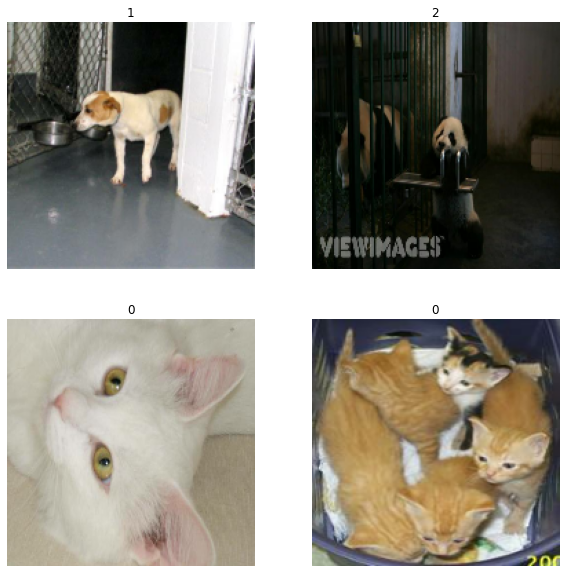

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Augmenting the Data

In this step we increase our dataset size and variety by taking our photos and flipping them, and rotating them.  


In [4]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

Here we can display what the data augmentation step accompishes by taking  1 original photo, and applying the augment step 9 times.  

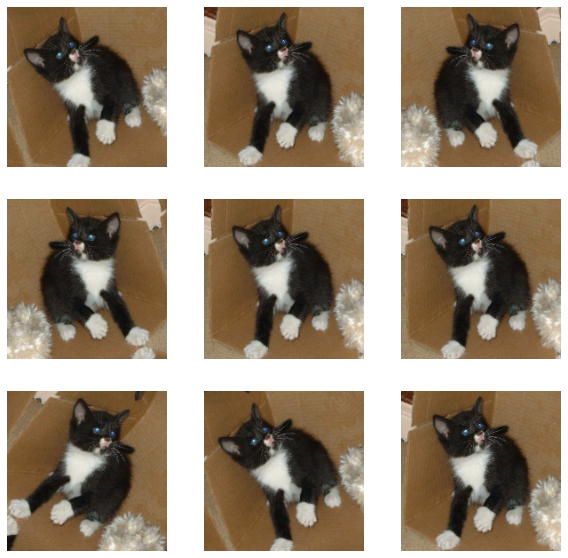

In [5]:
import matplotlib.pyplot as plt  # Import Matplotlib's pyplot for plotting

plt.figure(figsize=(10, 10))  # Create a new 10x10 inch figure for plotting

# Loop through a batch of images in the training dataset
for images, _ in train_ds.take(1):
    # Iterate to display 9 images
    for i in range(9):
        augmented_images = data_augmentation(images)  # Apply data augmentation to the images
        ax = plt.subplot(3, 3, i + 1)  # Create a subplot in a 3x3 grid
        plt.imshow(augmented_images[0].numpy().astype("uint8"))  # Display the first augmented image
        plt.axis("off")  # Turn off the axis



In [2]:
import numpy as np

# Take one batch of the dataset
for images, labels in train_ds.take(1):
    first_image = images[0]  # Get the first image tensor
    first_image_array = first_image.numpy()  # Convert to numpy array

    # Print the numeric representation of the first image
    print(first_image_array)

    # If you want to print with less decimal places to make it easier to read:
    # np.set_printoptions(precision=2, suppress=True)
    # print(first_image_array)

    break  # Only take the first batch, so break here

[[[118.94444  123.552315 108.349686]
  [154.19537  163.23009  150.66296 ]
  [165.3068   177.91791  168.52902 ]
  ...
  [154.99289  160.43332  158.7131  ]
  [159.64404  164.44495  164.71118 ]
  [169.39188  173.87227  176.87227 ]]

 [[128.43658  132.43658  117.43658 ]
  [157.11945  164.95279  152.78612 ]
  [166.91621  177.52731  169.13843 ]
  ...
  [173.08282  174.76616  173.9245  ]
  [187.30563  188.28758  189.814   ]
  [193.48729  194.32896  198.0123  ]]

 [[108.62577  112.29398   97.45988 ]
  [150.65741  156.82407  145.49074 ]
  [164.49228  174.49228  166.1034  ]
  ...
  [198.06781  195.86336  198.0439  ]
  [226.09505  222.73622  226.03253 ]
  [231.76683  228.6966   232.01604 ]]

 ...

 [[119.416626 129.41663  129.61108 ]
  [120.0856   129.5856   131.91663 ]
  [123.04162  128.20828  136.99841 ]
  ...
  [116.4722   124.239944 127.93671 ]
  [108.48596  116.48596  119.48596 ]
  [129.87451  137.87451  140.87451 ]]

 [[124.941376 134.94138  133.94138 ]
  [126.248314 135.7483   137.58165 ]


In [6]:


# Apply data augmentation to each image in the training dataset and keep labels the same
##augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

train_ds = train_ds.prefetch(buffer_size=32)  # Prefetch data for training dataset to improve loading efficiency
val_ds = val_ds.prefetch(buffer_size=32)  # Prefetch data for validation dataset to improve loading efficiency

Here we will actually construct the NN model used for image classification.  The model itself is a basic image processing 2D Convolution Neural Network.  For more information on why this particular model is used for image classification:

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

## Create function to Create our Keras Model using Functional API
##Functional API : start by creating input node with Keras.Input, finish with Keras.Model(input,output)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)  # Define model input shape
    # Assume data_augmentation is defined elsewhere
    x = data_augmentation(inputs)  # Apply data augmentation

    x = layers.Rescaling(1.0 / 255)(x)  # Rescale pixel values
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)  # Apply 2D convolution
    x = layers.BatchNormalization()(x)  # Normalize the activations
    x = layers.Activation("relu")(x)  # Apply ReLU activation

    # Adding MaxPooling right after the first convolution
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)  # Apply 2D convolution
    x = layers.BatchNormalization()(x)  # Normalize the activations
    x = layers.Activation("relu")(x)  # Apply ReLU activation

    previous_block_activation = x  # Store current layer output

    # Simplify the loop for creating multiple layers to accommodate the new MaxPooling
    for size in [128, 256]:
        x = layers.Activation("relu")(x)  # Apply ReLU activation
        x = layers.SeparableConv2D(size, 3, padding="same")(x)  # Apply separable convolution
        x = layers.BatchNormalization()(x)  # Normalize the activations

        x = layers.Activation("relu")(x)  # Apply ReLU activation
        x = layers.SeparableConv2D(size, 3, padding="same")(x)  # Apply separable convolution
        x = layers.BatchNormalization()(x)  # Normalize the activations

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)  # Apply max pooling

        # Create residual connection
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add residual connection
        previous_block_activation = x  # Update residual for next block

    # Continue with the final layers of the model as before
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)  # Apply separable convolution
    x = layers.BatchNormalization()(x)  # Normalize the activations
    x = layers.Activation("relu")(x)  # Apply ReLU activation

    x = layers.GlobalAveragePooling2D()(x)  # Apply global average pooling
    x = layers.Dropout(0.5)(x)  # Apply dropout for regularization

    # Conditional block for output layer settings
    if num_classes == 2:
        activation = "sigmoid"  # Set activation for binary classification
        units = 1  # Set single unit for binary classification
    else:
        activation = "softmax"  # Set activation for multi-class classification
        units = num_classes  # Set units equal to number of classes

    outputs = layers.Dense(units, activation=activation)(x)  # Create output layer
    return keras.Model(inputs, outputs)  # Return the model

# Example usage, assuming 'image_size' and 'data_augmentation' are defined elsewhere
model = make_model(input_shape=image_size + (3,), num_classes=3)

In [12]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
75/75 [==============================] - 112s 1s/step - loss: 0.9161 - accuracy: 0.5858 - val_loss: 1.3002 - val_accuracy: 0.3133
Epoch 2/50
75/75 [==============================] - 111s 1s/step - loss: 0.6972 - accuracy: 0.6592 - val_loss: 1.7680 - val_accuracy: 0.3133
Epoch 3/50
75/75 [==============================] - 114s 2s/step - loss: 0.6966 - accuracy: 0.6725 - val_loss: 1.8252 - val_accuracy: 0.3133
Epoch 4/50
75/75 [==============================] - 112s 1s/step - loss: 0.6234 - accuracy: 0.6946 - val_loss: 1.8984 - val_accuracy: 0.3133
Epoch 5/50
75/75 [==============================] - 112s 1s/step - loss: 0.5692 - accuracy: 0.7233 - val_loss: 2.2414 - val_accuracy: 0.3133
Epoch 6/50
75/75 [==============================] - 111s 1s/step - loss: 0.5388 - accuracy: 0.7367 - val_loss: 1.9300 - val_accuracy: 0.3133
Epoch 7/50
75/75 [==============================] - 112s 1s/step - loss: 0.5157 - accuracy: 0.7579 - val_loss: 1.7585 - val_accuracy: 0.3167
Epoch 8/50
75

In [8]:
val_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
from tensorflow import keras

# Replace 'path_to_my_checkpoint.h5' with the actual path to your checkpoint file
model_checkpoint_path = 'save_at_50.h5'

# Load the model from the checkpoint
model = keras.models.load_model(model_checkpoint_path)

# After loading, you can use the model to make predictions, evaluate it, or continue training

In [10]:
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation accuracy: {val_accuracy*100:.2f}%")

19/19 [==============================] - 7s 341ms/step - loss: 0.5862 - accuracy: 0.8100
Validation accuracy: 81.00%


In [21]:
img = keras.preprocessing.image.load_img(
    "D:\\Downloads\\dogphoto1.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(score)

[0.4353914  0.561075   0.00353362]
